# Classical Shadows

The output of a quantum computer is a histogram of measurements, corresponding to the different outcomes observed, usually expressed as bitstrings. The cost and duration of a quantum experiment is roughly linear with the number of shots used to build such histograms, which also correlates with the accuracy of the results. The emergent method classical shadows ([Nat. Phys. 2020, 16, 1050–1057](https://arxiv.org/abs/2002.08953)) have been developed to mitigate the measurement overhead by offloading quantum tasks to the pre- and post-processing steps. This prediction protocol exhibits logarithmic scaling with the number of shots to evaluate observables within a wanted accuracy.

In short, gates representing a unitary are appended to the state encoded in a quantum circuit. An experiment is carried out and the output bitstring (100101..) is stored in a conventional register. This is repeated $N$ times, where $N$ defines the shadow size. Observables are computed from this representation called a "classical shadow". Different classical shadow flavours exist, as they come with a specific protocol for choosing a set of unitaries. The figure below, taken from  taken from [Nat. Phys. 16, 1050–1057 (2020)](https://arxiv.org/abs/2002.08953), illustrates the protocol.

![Classical Shadows overview](img/classical_shadow_overview.png "Classical Shadow")

Users can leverage this protocol by performing the relevant pre- and post-processing functions, as introduced in this notebook. The randomized, derandomized and adaptive single-qubit Pauli basis classical shadows are currently available in Tangelo.

## System
To demonstrate the classical shadow capabilities, we first define a molecular system composed of two hydrogen atoms in the 3-21G basis. When translated a qubit-compatible language, the scBK-Hamiltonian acts on 6 qubits.

In [1]:
from tangelo.molecule_library import mol_H2_321g
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
from tangelo.toolboxes.operators import count_qubits

# Encoding options.
encoding = "scBK"
up_then_down = True

# Converting the fermionic Hamiltonian according to the encoding options.
qubit_ham = fermion_to_qubit_mapping(mol_H2_321g.fermionic_hamiltonian, 
                                     encoding, 
                                     n_spinorbitals=mol_H2_321g.n_active_sos, 
                                     n_electrons=mol_H2_321g.n_active_electrons, 
                                     up_then_down=up_then_down)

print(f"Number of qubits to describe the system: {count_qubits(qubit_ham)}")

Number of qubits to describe the system: 6


For this example, the qubit coupled-cluster (QCC) ansatz have been chosen ([J. Chem. Theory Comput. 2018, 14(12), 6317–6326](https://pubs.acs.org/doi/10.1021/acs.jctc.8b00932)). While the depth of the circuit rapidly increases as the size of the molecule increases, the QCC ansatz admits a low-depth quantum circuit compared to a widely used unitary coupled-cluster single and double (UCCSD) ansatz. 

In [2]:
from tangelo.toolboxes.ansatz_generator.qcc import QCC

ansatz = QCC(mol_H2_321g, mapping=encoding, up_then_down=up_then_down)
ansatz.build_circuit()

print(f"Number of gates in the circuit: {ansatz.circuit.size}")

Number of gates in the circuit: 79


The Variational Quantum Eigensolver (VQE) has been introduced in another notebook as a hybrid quantum–classical algorithm for simulating quantum systems. In the next cell, we focus on VQE within the context of minimizing the QCC variational parameters in respect to the 3-21G dihydrogen energy.

In [3]:
from tangelo.algorithms.variational import VQESolver

vqe = VQESolver({"qubit_hamiltonian": qubit_ham, "ansatz": ansatz.circuit})
vqe.build()
energy_ref = vqe.simulate()
print(f"Energy from statevector simulation: {energy_ref:.4f} hartree")

Energy from statevector simulation: -1.1475 hartree


Now, we can refer to the optimized circuit with the `vqe.optimal_circuit` keyword and we know that with the provided Hamiltonian, the ideal energy is -1.1475 hartree. A visual representation of the circuit is shown below.

![QCC circuit for H2 in 3-21G basis](img/H2_321g_QCC.png "QCC circuit")

## Reference values
We want to acquire a reference value to evaluate the efficacy of classical shadows. One of the state-of-the-art method is the qubitwise commutativity accessible with the `group_qwc` function. It defines the minimal number of basis to measure by identifying commutating terms. Then, the number of shots can be distributed equally or according to a heuristic that considers the term coefficients.

The reference value compute in the next cell only contains statistical errors and no quantum noise, 
even though it is always present in hardware. This shot-based simulation culminates with an energy containing an  error $\epsilon$, inherent to the finite numbers of measurements. This error $\epsilon$ will be compared to the ones coming from classical shadow protocols. A user who wants to compare noisy values can do it so by providing the appropriate `noise_model` to the `Simulator` defined in the next cell. 

In [4]:
from tangelo.toolboxes.operators import QubitOperator
from tangelo.toolboxes.measurements import group_qwc, exp_value_from_measurement_bases
from tangelo.linq import Simulator, Circuit
from tangelo.linq.helpers import measurement_basis_gates

# Performing qubit-wise commutativity.
qubitwise_measurements = group_qwc(qubit_ham)

# Dividing the available number of shots equally for the amount of identified basis.
n_shots_budget = 10000
n_shots_per_basis = round(n_shots_budget / len(qubitwise_measurements))

# Shot-based backend.
backend = Simulator("cirq", n_shots=n_shots_per_basis, noise_model=None)

# Computing the histograms for the grouped basis.
qubitwise_results = dict()
for basis in qubitwise_measurements.keys():
    basis_circuit = Circuit(measurement_basis_gates(basis))
    qubitwise_results[basis], _ = backend.simulate(vqe.optimal_circuit + basis_circuit)

# Computing the energy from the histograms.
energy_shots = exp_value_from_measurement_bases(qubitwise_measurements, qubitwise_results)

print(f"Energy with qubit-wie commutativity and equally distributed shots: {energy_shots:.4f} hartree")
print(f"Error vs statevector simulation: {abs(energy_ref-energy_shots):.3f} hartree")

Energy with qubit-wie commutativity and equally distributed shots: -1.1507 hartree
Error vs statevector simulation: 0.003 hartree


## Classical Shadows
In this section, we will revisit the computation of the 3-21G dihydrogen energy with the QCC ansatz with the classical shadow protocols. Firstly, we change the number of shots in the backend to 1. Although it not required, a warning would appear and the number will be changed automatically.

In [5]:
backend.n_shots = 1

As stated at the beginning of this notebook, three classical shadow flavours are available in Tangelo. Each flavour has a distinct class: `RandomizedClassicalShadow`, `DerandomizedClassicalShadow` and `AdaptiveClassicalShadow`. Common methods `build` and `simulate` are defined to respectively construct the unitaries set and simulate results with a given backend.

### Randomized Single-Qubit Pauli Classical Shadows
Randomized classical shadows come from the original report. Random basis are constructed from the tensor product of random single-qubit Pauli gates ($X$, $Y$ or $Z$). The samples can then be inverted with a simple quantum channel

$$
\mathcal{M}_p^{-1} = \bigotimes_{i=1}^n \mathcal{M}_i^{-1}
$$

Observables can then be predicted from the median of means. More details can be found in [Nat. Phys. 16, 1050–1057 (2020)](https://arxiv.org/abs/2002.08953).

In [6]:
from tangelo.toolboxes.measurements import RandomizedClassicalShadow

random_cs = RandomizedClassicalShadow(vqe.optimal_circuit)
random_cs.build(n_shots_budget)
random_cs.simulate(backend)

energy_random = random_cs.get_observable(qubit_ham)
print(f"Energy from randomized single-Pauli classical shadow: {energy_random:.4f} hartree")
print(f"Error vs statevector simulation: {abs(energy_ref-energy_random):.3f} hartree")

Energy from randomized single-Pauli classical shadow: -0.8917 hartree
Error vs statevector simulation: 0.256 hartree


### Derandomized Single-Qubit Pauli Classical Shadows
The derandomized procedure comes to fix a problem with the randomized procedure. As the number of qubits increases, the probability of hitting long Pauli words in a qubit Hamiltonian decrease greatly. Therefore, bigger shadows are needed to compute an osbervable within a reasonable accuracy. The derandomized procedure uses a provided qubit operator to steer the basis choices, thus removing the randomness. This results in basis hitting the relevant operator systematically. More details on this algorithm can be found in [Phys. Rev. Lett. 127, 030503](https://arxiv.org/abs/2103.07510).

In [7]:
from tangelo.toolboxes.measurements import DerandomizedClassicalShadow

derandom_cs = DerandomizedClassicalShadow(vqe.optimal_circuit)
derandom_cs.build(n_shots_budget, qubit_ham)
derandom_cs.simulate(backend)

energy_derandom = derandom_cs.get_observable(qubit_ham)
print(f"Energy from derandomized single-Pauli classical shadow: {energy_derandom:.4f} hartree")
print(f"Error vs statevector simulation: {abs(energy_ref-energy_derandom):.3f} hartree")

Energy from derandomized single-Pauli classical shadow: -1.1530 hartree
Error vs statevector simulation: 0.006 hartree


### Adaptive Single-Qubit Pauli Classical Shadows
Another procedure for choosing single-qubit Pauli basis is an adaptive one. It uses an iterative process to draw a Pauli gate for each qubit, one at the time. The probability distributions are built so the next single-qubit Pauli gates drawn will depend on the measurement bases already assigned to previous qubits. This shifts the single-qubit Pauli basis choice towards terms hitting a provided operator, while keeping a fair amount of randomness to extent the state characterization coverage. For more details on this algorithm, we refer to [arXiv:2105.12207](https://arxiv.org/abs/2105.12207).

In [8]:
from tangelo.toolboxes.measurements import AdaptiveClassicalShadow

adaptive_cs = AdaptiveClassicalShadow(vqe.optimal_circuit)
adaptive_cs.build(n_shots_budget, qubit_ham)
adaptive_cs.simulate(backend)

energy_adaptive = adaptive_cs.get_observable(qubit_ham)
print(f"Energy from adaptive single-Pauli classical shadow: {energy_adaptive:.4f} hartree")
print(f"Error vs statevector simulation: {abs(energy_ref-energy_adaptive):.3f} hartree")

Energy from adaptive single-Pauli classical shadow: -1.1505 hartree
Error vs statevector simulation: 0.003 hartree


## More data...
Due to the nature of the classical shadow processes, there is a random component during evaluation of observables. This is why your mileage may vary if you try to rerun all code cells in this notebook. To better portray the situation, we preran 10 simulations of 10 000 shots for all the methods and the results (energy in hartree vs the FCI value) are shown in the plot below. The ideal energy (0.0 vs FCI) is represented by the dashed line.

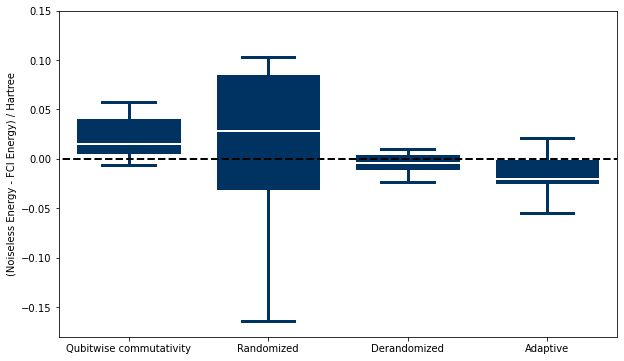

In [9]:
import matplotlib.pyplot as plt
import numpy as np

data = np.array([
    [ 0.00508,  0.02309, -0.03742, -0.02013],
    [ 0.01601, -0.16360, -0.02321, -0.02002],
    [ 0.04252,  0.03412,  0.00546, -0.05518],
    [ 0.01322,  0.10274,  0.00458,  0.02129],
    [ 0.05665, -0.01826, -0.00687, -0.01218],
    [ 0.05709, -0.08834, -0.01307,  0.00555],
    [-0.00185,  0.07029,  0.00910, -0.02183],
    [ 0.03663,  0.09825, -0.00555,  0.00459],
    [-0.00593,  0.09175, -0.00332, -0.04029],
    [ 0.00574, -0.03616,  0.00986, -0.02638]
])

_, ax = plt.subplots(figsize=(10,6))
VP = ax.boxplot(data, positions=[2, 4, 6, 8], 
                labels=["Qubitwise commutativity", "Randomized", "Derandomized", "Adaptive"],
                widths=1.5, patch_artist=True,
                showmeans=False, showfliers=False,
                medianprops={"color": "white", "linewidth": 2},
                boxprops={"facecolor": "#003262", "edgecolor": "white", "linewidth": 1},
                whiskerprops={"color": "#003262", "linewidth": 3},
                capprops={"color": "#003262", "linewidth": 3})

ax.set(ylim=(-.18, .15), xlim=(1, 9))
ax.hlines(y=0., xmin=0, xmax=10, linewidth=2, color="k", linestyles="dashed")

ax.set_ylabel(r"(Noiseless Energy - FCI Energy) / Hartree")
plt.show()

For the noiseless case, the plot shows an advantage of using the derandomized and adaptive single-qubit Pauli classical shadows for a given number of shots. The case is not so clear regarding randomized classical shadows. Several studies have taken a look at the noise implication of predicting observables with shadows ([arXiv:2011.09636](https://arxiv.org/abs/2011.09636) and [arXiv:2011.11580](https://arxiv.org/abs/2011.11580)). Those evidences point to a noise robustness inherent to this mesaurement procedure, especially when in comparison with the simpler qubitwise commutativity protocol.

## Closing words
We demonstrated the use of several classical shadow protocols in this notebook. As their theoretical scaling is logarithmic with the number of shots, their potential is significant. In this notebook, we witness that this scaling advantage may not be noticeable with the small system studied here (6 qubits). Nevertheless, some studies relate resilience of classical shadows in respect to noise. 

## References
1. Chen, S., Yu, W., Zeng, P. & Flammia, S. T. Robust shadow estimation. arXiv:2011.09636 [quant-ph] (2020).
2. Koh, D. E. & Grewal, S. Classical Shadows with Noise. arXiv:2011.11580 [math-ph, physics:quant-ph] (2020).
3. Huang, H.-Y., Kueng, R. & Preskill, J. Efficient estimation of Pauli observables by derandomization. arXiv:2103.07510 [quant-ph] (2021).
4. Hadfield, C. Adaptive Pauli Shadows for Energy Estimation. arXiv:2105.12207 [quant-ph] (2021).
5. Huang, H. Y., Kueng, R. & Preskill, J. Predicting many properties of a quantum system from very few measurements. Nature Physics 16, 1050–1057 (2020).